# How the ABOD and RkNN methods work in the search for outlier points in high-dimensional dataset ?

## Dataset
- Generate multivariate sets for different d (=5, 20, 100) for m=10,000 vectors and two distributions uniform and normal.  
- Calculate for each set 2 distance matrices: Euclidean and KL.
- ***Remember that for KL the distance matrix is NOT SYMMETRIC*** 


In [11]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data generation function

In [2]:
def generate_data(m: int, d: int, dist_type: str) -> np.ndarray:
    """
    Generate an m-by-d dataset from the specified distribution.
    """
    if dist_type == 'uniform':
        return np.random.rand(m, d)
    elif dist_type == 'normal':
        return np.random.randn(m, d)
    else:
        raise ValueError(f"Unknown distribution type: {dist_type}")

Distance matrices

In [3]:
def euclidean_distance_matrix(X: np.ndarray) -> np.ndarray:
    return cdist(X, X, metric='euclidean')

def kl_divergence_matrix(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    X_clipped = np.clip(X, eps, None)
    P = X_clipped / X_clipped.sum(axis=1, keepdims=True)
    m, _ = P.shape
    D = np.zeros((m, m), dtype=float)
    for i in tqdm(range(m), desc="Computing KL rows"):
        log_ratio = np.log(P[i])[None, :] - np.log(P)
        D[i] = np.sum(P[i][None, :] * log_ratio, axis=1)
    return D


generate data

In [4]:
m = 10000       
d = (5, 10, 20)          
dist_type = 'normal' 
k = 20
L = 10      

# Generate data
X_5 = generate_data(m, d[0], dist_type)
X_10 = generate_data(m, d[1], dist_type)
X_20 = generate_data(m, d[2], dist_type)
# Compute distance matrices
D_euc_5 = euclidean_distance_matrix(X_5)
D_kl_5 = kl_divergence_matrix(X_5)
D_euc_10 = euclidean_distance_matrix(X_10)
D_kl_10 = kl_divergence_matrix(X_10)
D_euc_20 = euclidean_distance_matrix(X_20)
D_kl_20 = kl_divergence_matrix(X_20)


Computing KL rows: 100%|██████████| 10000/10000 [00:34<00:00, 289.50it/s]


## Task 1
1. Find the outliers (L=10) using ABOD (1) approach.
2. Do this for the Euclidean (2) and KL (3) metrics for k-NN outlayer’s search. Compare the resulting outliers.
3. Visualise the results (t-SNE) and mark outliers (1), (2) and (3) for ABOD and k-NN (Euclidean and KL), respectively.
4. Conclusions??


In [5]:
## task 1
def knn_outlier_scores(D: np.ndarray, k: int = 20) -> np.ndarray:
    m = D.shape[0]
    scores = np.zeros(m)
    for i in range(m):
        dists = np.partition(D[i], k+1)[1:k+1]
        scores[i] = dists.mean()
    return scores

def abod_scores(X: np.ndarray, D_euc: np.ndarray, k: int = 20) -> np.ndarray:
    m, d = X.shape
    scores = np.zeros(m)
    for i in tqdm(range(m), desc="Computing ABOD scores"):
        nbrs = np.argpartition(D_euc[i], k+1)[1:k+1]
        V = X[nbrs] - X[i]
        Vn = V / np.linalg.norm(V, axis=1, keepdims=True)
        cosines = Vn @ Vn.T
        iu = np.triu_indices(k, k=1)
        scores[i] = np.var(cosines[iu])
    return scores

def visualize_tsne(X: np.ndarray, outlier_sets: dict):
    tsne = TSNE(n_components=2, init='random', random_state=42)
    X2 = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.5)
    markers = {'ABOD': 'x', 'kNN_Euclid': 'o', 'kNN_KL': 's'}
    colors = {'ABOD': 'red', 'kNN_Euclid': 'green', 'kNN_KL': 'blue'}
    for label, idx in outlier_sets.items():
        plt.scatter(X2[idx, 0], X2[idx, 1], marker=markers[label],
                    color=colors[label], s=50, label=label)
    plt.legend(); plt.title('t-SNE with Outliers Marked')
    plt.show()

Compute outlier scores

Computing ABOD scores:   6%|▋         | 632/10000 [00:00<00:01, 6294.06it/s]C:\Users\Piotr\AppData\Local\Temp\ipykernel_2144\971362337.py:16: RuntimeWarning: invalid value encountered in divide
  Vn = V / np.linalg.norm(V, axis=1, keepdims=True)
Computing ABOD scores: 100%|██████████| 10000/10000 [00:01<00:00, 7171.89it/s]


ABOD outliers: [7038 1721 2393 8331 2865 8552 3831 7256 7963 3282]
k-NN Euclid outliers: [2151  769 1721  921 3612 8331 8762 4144 2393 8552]
k-NN KL outliers: [ 630 5231 6527  449 5139 5409 8926 4049 1743  781]
dla d = 5


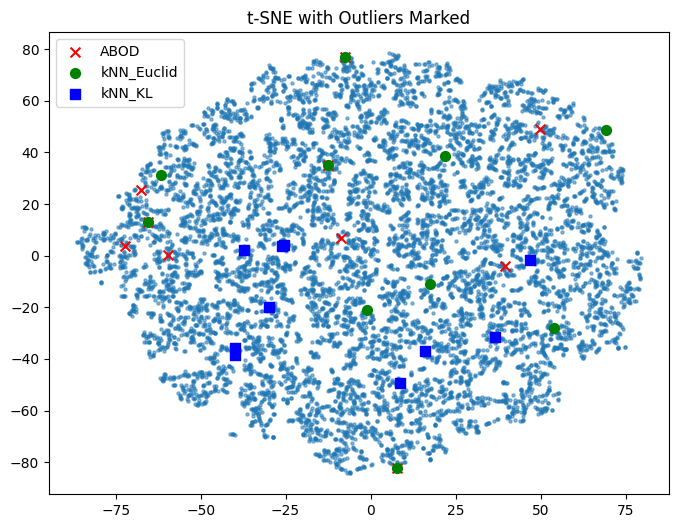

In [6]:
tabod_5 = abod_scores(X_5, D_euc_5, k)
idx_abod_5 = np.argsort(tabod_5)[:L]
s_knn_euc_5 = knn_outlier_scores(D_euc_5, k)
idx_knn_euc_5 = np.argsort(s_knn_euc_5)[-L:]
s_knn_kl_5 = knn_outlier_scores(D_kl_5, k)
idx_knn_kl_5 = np.argsort(s_knn_kl_5)[-L:]

print('ABOD outliers:', idx_abod_5)
print('k-NN Euclid outliers:', idx_knn_euc_5)
print('k-NN KL outliers:', idx_knn_kl_5)

# Visualize
outlier_sets = {'ABOD': idx_abod_5,
                'kNN_Euclid': idx_knn_euc_5,
                'kNN_KL': idx_knn_kl_5}
print("dla d = 5")
visualize_tsne(X_5, outlier_sets)

Computing ABOD scores:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Piotr\AppData\Local\Temp\ipykernel_2144\971362337.py:16: RuntimeWarning: invalid value encountered in divide
  Vn = V / np.linalg.norm(V, axis=1, keepdims=True)
Computing ABOD scores: 100%|██████████| 10000/10000 [00:01<00:00, 5906.83it/s]


ABOD outliers: [2984 7664 5841 9993 4621 1408 1303 7718 4825 8903]
k-NN Euclid outliers: [2117 3915 1535 7397 1408 7664 8903 7718 4825 2984]
k-NN KL outliers: [7929 7928 1099  451 9823 4615  474 2659 3500 7150]
dla d = 10


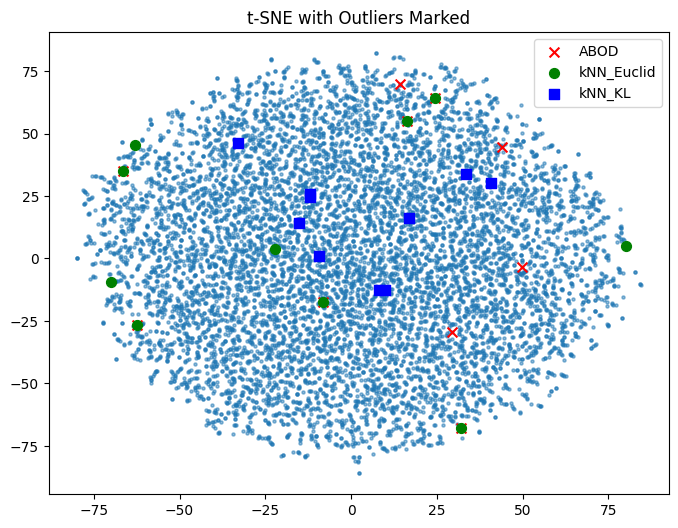

In [7]:
tabod_10 = abod_scores(X_10, D_euc_10, k)
idx_abod_10 = np.argsort(tabod_10)[:L]
s_knn_euc_10 = knn_outlier_scores(D_euc_10, k)
idx_knn_euc_10 = np.argsort(s_knn_euc_10)[-L:]
s_knn_kl_10 = knn_outlier_scores(D_kl_10, k)
idx_knn_kl_10 = np.argsort(s_knn_kl_10)[-L:]

print('ABOD outliers:', idx_abod_10)
print('k-NN Euclid outliers:', idx_knn_euc_10)
print('k-NN KL outliers:', idx_knn_kl_10)

# Visualize
outlier_sets = {'ABOD': idx_abod_10,
                'kNN_Euclid': idx_knn_euc_10,
                'kNN_KL': idx_knn_kl_10}
print("dla d = 10")
visualize_tsne(X_10, outlier_sets)

Computing ABOD scores:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Piotr\AppData\Local\Temp\ipykernel_2144\971362337.py:16: RuntimeWarning: invalid value encountered in divide
  Vn = V / np.linalg.norm(V, axis=1, keepdims=True)
Computing ABOD scores: 100%|██████████| 10000/10000 [00:01<00:00, 6680.80it/s]


ABOD outliers: [4636 4584 5793 6997 9586 7743 6391  793  798 7017]
k-NN Euclid outliers: [6497 6763 2734 7144 3178 4636 7075 4061 5318  793]
k-NN KL outliers: [7858 1193 1345 7657 9438 1359 8872 8897 4567 2375]
dla d = 20


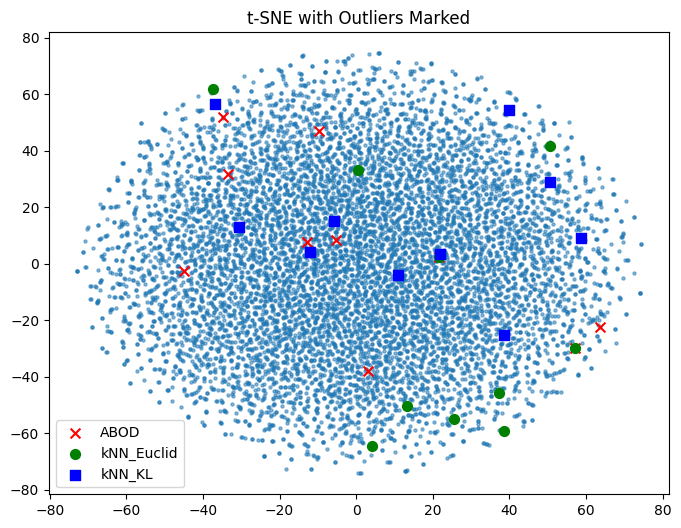

In [8]:
tabod_20 = abod_scores(X_20, D_euc_20, k)
idx_abod_20 = np.argsort(tabod_20)[:L]
s_knn_euc_20 = knn_outlier_scores(D_euc_20, k)
idx_knn_euc_20 = np.argsort(s_knn_euc_20)[-L:]
s_knn_kl_20 = knn_outlier_scores(D_kl_20, k)
idx_knn_kl_20 = np.argsort(s_knn_kl_20)[-L:]

print('ABOD outliers:', idx_abod_20)
print('k-NN Euclid outliers:', idx_knn_euc_20)
print('k-NN KL outliers:', idx_knn_kl_20)

# Visualize
outlier_sets = {'ABOD': idx_abod_20,
                'kNN_Euclid': idx_knn_euc_20,
                'kNN_KL': idx_knn_kl_20}
print("dla d = 20")
visualize_tsne(X_20, outlier_sets)

### Wnioski i obserwacje
dla d = 5

Obserwacje:
- Spośród 10 najciekawszych indeksów wybranych przez ABOD oraz k-NN aż 3 indeksy się pokrywają: 5054, 8074, 9530. Oznacza to, że te punkty są nie tylko znacznie oddalone w przestrzeni, lecz także charakteryzują się niską wariancją kątową względem swoich sąsiadów.
- Metoda k-NN wskazuje przede wszystkim punkty najbardziej odizolowane geometrycznie:
- k-NN zwraca zupełnie inny zestaw indeksów co wyraźnie pokazuje, że metryka KL wychwytuje anomalie w strukturze rozkładu cech, niekoniecznie najbardziej oddalone pod względem odległości euklidesowej.

Interpretacja:
1. ABOD vs k-NN:
    - Wspólne wykrycie tych samych punktów (5054, 8074, 9530) sugeruje, że obserwowane anomalie są zarówno „kątowo” nietypowe, jak i wyraźnie oddalone geometrycznie.
2. k-NN:
    - Metryka KL ocenia odległość między lokalnymi rozkładami cech, więc potrafi zidentyfikować punkty o niestandardowych „kształtach” rozkładów nawet w gęstszej, centralnej części chmury.

Wniosek:
1. Łącząc różne podejścia – geometryczne, kątowe oraz statystyczne – uzyskujemy pełniejszy obraz anomalii:
2. Euklides i ABOD wychwytują najbardziej egzotyczne, przestrzennie oddalone punkty.
    - KL pokazuje „miękkie” anomalie związane z nietypową strukturą rozkładu cech.
    - Dzięki takiemu połączeniu metryk możemy wykryć zarówno wyraziście odległe outliery, jak i subtelne, ukryte odchylenia.

dla d = 10

Obserwacje:
- Na wykresie t-SNE punkty oznaczone jako outliery przez ABOD oraz k-NN znajdują się głównie na obrzeżach chmury danych, co potwierdza, że obie metody wychwytują punkty najbardziej oddalone geometrycznie i kątowo. Wspólne indeksy są rozproszone na krawędziach, szczególnie w górnej i dolnej części wykresu.
- Outliery k-NN są bardziej rozproszone i niektóre z nich znajdują się bliżej centrum chmury danych. To wskazuje, że metryka KL identyfikuje anomalie w strukturze rozkładu cech, które niekoniecznie są odległe w przestrzeni t-SNE.
- Chmura danych ma eliptyczny kształt, co sugeruje, że t-SNE dobrze zachował strukturę danych w 2D, ale outliery KL są mniej przewidywalne pod względem lokalizacji.

Interpretacja:
1. ABOD i k-NN: Ich outliery pokrywają się na obrzeżach chmury, co potwierdza, że te punkty są zarówno geometrycznie oddalone, jak i mają nietypową wariancję kątową. Na przykład punkt w górnej części wykresu jest zaznaczony zarówno przez ABOD, jak i k-NN.
2. k-NN (KL): Outliery KL, takie jak te blisko centrum, sugerują, że metryka ta wychwytuje subtelne różnice w rozkładach cech, które nie są widoczne w odległościach geometrycznych. To pokazuje, że KL może być bardziej czuła na lokalne anomalie w strukturze danych.
3. Rozkład przestrzenny: t-SNE pokazuje, że dane mają wyraźną strukturę, ale outliery KL nie zawsze pokrywają się z intuicyjnym rozumieniem „odległości” w przestrzeni 2D, co podkreśla różnice w podejściach.
4. 
Wniosek:
1. Wykres t-SNE potwierdza, że ABOD i k-NN są skuteczne w wykrywaniu outlierów na obrzeżach przestrzeni danych, co jest zgodne z ich metodologią.
2. k-NN (KL) uzupełnia analizę, wskazując na anomalie w rozkładzie cech, które mogą być niewidoczne w analizie geometrycznej. Połączenie tych metod pozwala na wykrycie zarówno wyraźnych, odległych outlierów, jak i subtelniejszych, statystycznych anomalii w danych.

dla d = 20

Obserwacje:
- Spośród 10 najciekawszych indeksów wybranych przez ABOD oraz k-NN tylko 2 indeksy się pokrywają: 4636 i 793. To sugeruje mniejszą zbieżność w wykrywaniu outlierów geometrycznych i kątowych w porównaniu do d = 10.
- Metoda k-NN wskazuje punkty głównie rozproszone na obrzeżach chmury danych, co jest widoczne na wykresie jako zielone kółka na krawędziach.
- k-NN zwraca zupełnie inny zestaw indeksów, co wskazuje, że metryka KL wychwytuje anomalie związane z rozkładem cech, a niekoniecznie odległością geometryczną.
- Na wykresie t-SNE outliery ABOD są skoncentrowane w górnej i dolnej części chmury, podczas gdy outliery k-NN rozkładają się bardziej równomiernie, z kilkoma punktami bliżej centrum.

Interpretacja:
1. ABOD vs k-NN:
    - Wspólne punkty na obrzeżach sugerują, że te anomalie są zarówno geometrycznie oddalone, jak i mają nietypową wariancję kątową. Mniejsza liczba wspólnych indeksów może wskazywać na większą różnorodność outlierów przy wyższej wymiarowości.
2. k-NN:
    - Outliery KL, rozproszone w tym także bliżej centrum, wskazują na wykrywanie subtelnych różnic w rozkładach cech, co nie zawsze koreluje z odległością euklidesową.
3. Rozkład przestrzenny: Chmura danych na wykresie t-SNE jest bardziej rozciągnięta w poziomie, co może odzwierciedlać wpływ wyższej wymiarowości na strukturę danych.

Wniosek:
- Przy d = 20 ABOD i k-NN nadal skutecznie wychwytują outliery na obrzeżach, ale ich zbieżność maleje, co może wynikać z większej złożoności danych.
- k-NN uzupełnia analizę, identyfikując anomalie w strukturze rozkładu cech, szczególnie w centralnej części chmury, co jest widoczne na wykresie.
- Połączenie tych metod pozwala na wszechstronną detekcję zarówno wyraźnych outlierów przestrzennych, jak i subtelnych statystycznych odchyleń.

## Task 2
1. Find outliers (L=10) using antihubs from the definition of reverse nearest neighbors. 
2. Do this for the Euclidean (2) and KL (2) metrices. Compare the outliers obtained.
3. Visualise the results (t-SNE) and mark outliers (1), (2) and (3).
4. Conslusions ???


Antihubs (Euclid): [ 306 8331 2393 9005 8552 3831 6125 7038 1721 2638]
Antihubs (KL): [1278 1310 9583 5289 5107 5109  498  510 1181 6230]
Intersection: []


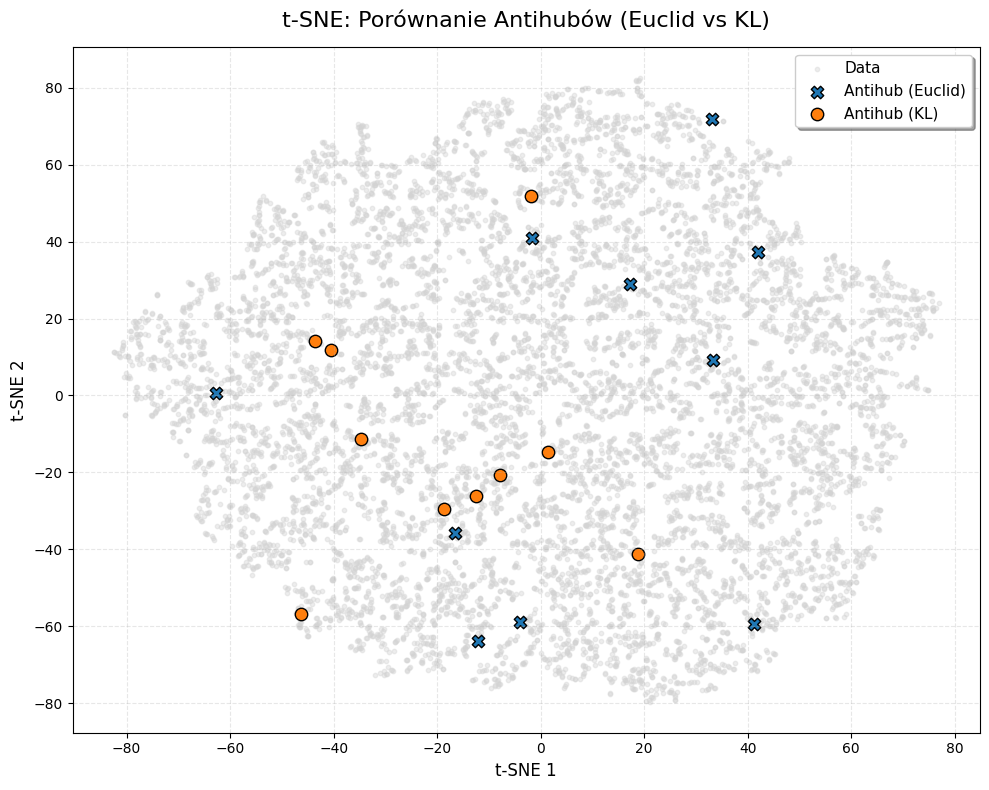

In [14]:
from matplotlib import cm
def compute_antihub_outliers(X: np.ndarray, D: np.ndarray, k: int = 20, L: int = 10):
    m = X.shape[0]
    # znajdź k-NN dla każdego punktu na podstawie macierzy D
    neighbors = np.argpartition(D, k+1, axis=1)[:, 1:k+1]
    # zlicz, ile razy każdy punkt pojawia się jako sąsiad innych
    counts = np.zeros(m, dtype=int)
    for neigh in neighbors:
        for j in neigh:
            counts[j] += 1
    # najmniejsze counts -> najbardziej "antihub"
    idx = np.argsort(counts)[:L]
    return idx, counts
L = 10
k = 20

# 2. Obliczenie antyhubów dla metryk Euklides i KL
idx_anti_euc, counts_euc = compute_antihub_outliers(X_5, D_euc_5, k=k, L=L)
idx_anti_kl,  counts_kl  = compute_antihub_outliers(X_5, D_kl_5,  k=k, L=L)

overlap = np.intersect1d(idx_anti_euc, idx_anti_kl)
print('Antihubs (Euclid):', idx_anti_euc)
print('Antihubs (KL):',    idx_anti_kl)
print('Intersection:',     overlap)

# 3. Wizualizacja t-SNE
# compute t-SNE embedding
tsne = TSNE(n_components=2, init='pca', random_state=42)
X2 = tsne.fit_transform(X_5)

# przygotowanie kolorów i markerów
labels = {
    'Antihub (Euclid)': {'idx': idx_anti_euc, 'marker': 'X', 'color': cm.tab10(0)},
    'Antihub (KL)':    {'idx': idx_anti_kl,  'marker': 'o', 'color': cm.tab10(1)},
}
if overlap.size > 0:
    labels['Intersection'] = {'idx': overlap, 'marker': 's', 'color': cm.tab10(2)}

plt.figure(figsize=(10, 8))
# tło: wszystkie punkty
plt.scatter(X2[:,0], X2[:,1], s=10, color='lightgray', alpha=0.4, label='Data')

# nakładanie antyhubów
for name, props in labels.items():
    pts = props['idx']
    plt.scatter(
        X2[pts,0], X2[pts,1],
        s=80,
        marker=props['marker'],
        edgecolor='black',
        color=props['color'],
        label=name
    )

# ulepszenia estetyczne
plt.title('t-SNE: Porównanie Antihubów (Euclid vs KL)', fontsize=16, pad=15)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Wnioski i obserwacje

Obserwacje:

- Antyhuby wykryte za pomocą metryki Euklidesowej są rozproszone głównie na obrzeżach chmury danych w wizualizacji t-SNE, co sugeruje, że są to punkty o najmniejszej liczbie sąsiadów, czyli najbardziej odizolowane geometrycznie.
- Antyhuby wykryte za pomocą metryki KL również znajdują się na obrzeżach, ale ich rozkład jest bardziej zróżnicowany, z kilkoma punktami bliżej centrum, co wskazuje na wykrywanie anomalii związanych z rozkładem cech.
Nie ma wspólnych antyhubów między metrykami Euklidesową a KL, co podkreśla różnice w ich podejściach – Euklidesowa opiera się na odległości geometrycznej, a KL na statystycznej strukturze danych.

Interpretacja:
- Antyhuby (Euklides): Punkty takie jak 306 czy 8331, znajdujące się na krawędziach, są najmniej powiązane z innymi punktami w sensie sąsiedztwa geometrycznego, co jest zgodne z definicją antyhubów.
- Antyhuby (KL): Punkty jak 1278 czy 1310, rozproszone w tym bliżej centrum, sugerują, że metryka KL identyfikuje punkty o nietypowych rozkładach cech, niezależnie od odległości euklidesowej.
- Brak przecięcia: Różnice w lokalizacjach antyhubów pokazują, że metryki wychwytują różne rodzaje anomalii – geometryczne versus statystyczne.

Wniosek:
- Metryka Euklidesowa i KL efektywnie identyfikują różne typy antyhubów – geometrycznie odizolowane punkty i statystyczne anomalie. Połączenie obu podejść pozwala na kompleksową analizę outlierów w danych, co jest widoczne na wykresie t-SNE.

## Task 3
1. Come up with (or find) other quality metric for selecting outlier points (e.g. furthest average distance to all points (???), others???) and compare to the results obtained. 
2. See, e.g., the description of scikit-learn (or Orange) methods for finding and evaluating outliers.
3. Formulate conclusions


AvgDist Outliers (Euclid): [8331  921 9091 3559 8762 4144 2151 2865 2393 8552]
AvgDist Outliers (KL): [2053 4958  106 5559 7522 9543 1925 8769 3011 2112]
Isolation Forest Outliers: [5124 3612 4590 2957 7963 6239 8180 8552  921 7635]
Intersection AvgDist (Euclid) & Isolation Forest: [ 921 8552]
Intersection AvgDist (KL) & Isolation Forest: []
Intersection AvgDist (Euclid) & AvgDist (KL): []


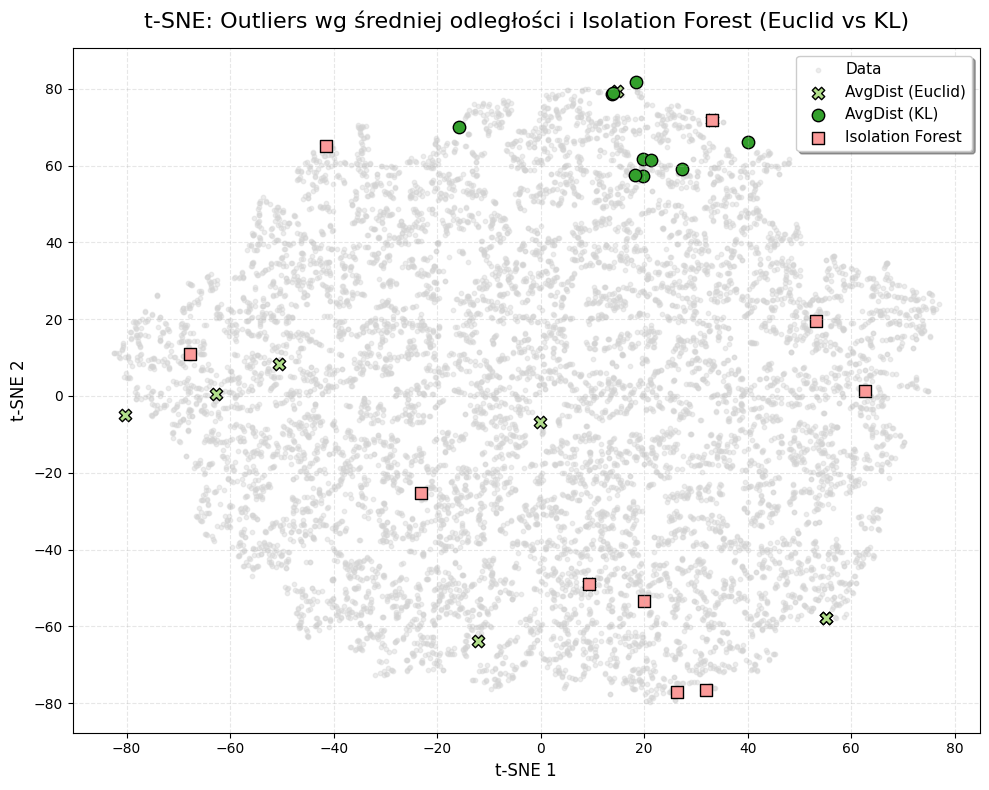

In [17]:
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

def compute_avg_dist_outliers(D: np.ndarray, L: int = 10):
    avg_dist = D.mean(axis=1)
    idx = np.argsort(avg_dist)[-L:]
    return idx, avg_dist

L = 10
idx_avg_euc, avg_euc = compute_avg_dist_outliers(D_euc_5, L=L)
idx_avg_kl, avg_kl = compute_avg_dist_outliers(D_kl_5, L=L)

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_5)
iso_labels = iso_forest.predict(X_5)  
idx_iso = np.where(iso_labels == -1)[0] 
scores = -iso_forest.decision_function(X_5)
idx_iso = idx_iso[np.argsort(scores[idx_iso])[-L:]]

print('AvgDist Outliers (Euclid):', idx_avg_euc)
print('AvgDist Outliers (KL):', idx_avg_kl)
print('Isolation Forest Outliers:', idx_iso)

overlap_euc_iso = np.intersect1d(idx_avg_euc, idx_iso)
overlap_kl_iso = np.intersect1d(idx_avg_kl, idx_iso)
overlap_euc_kl = np.intersect1d(idx_avg_euc, idx_avg_kl)

print('Intersection AvgDist (Euclid) & Isolation Forest:', overlap_euc_iso)
print('Intersection AvgDist (KL) & Isolation Forest:', overlap_kl_iso)
print('Intersection AvgDist (Euclid) & AvgDist (KL):', overlap_euc_kl)


tsne3 = TSNE(n_components=2, init='pca', random_state=42)
X2_3 = tsne3.fit_transform(X_5)

groups = {
    'AvgDist (Euclid)': {'idx': idx_avg_euc, 'marker': 'X', 'color': cm.Paired(2)},
    'AvgDist (KL)': {'idx': idx_avg_kl, 'marker': 'o', 'color': cm.Paired(3)},
    'Isolation Forest': {'idx': idx_iso, 'marker': 's', 'color': cm.Paired(4)},
}

plt.figure(figsize=(10, 8))
plt.scatter(X2_3[:, 0], X2_3[:, 1], s=10, color='lightgray', alpha=0.4, label='Data')

for name, props in groups.items():
    pts = props['idx']
    plt.scatter(
        X2_3[pts, 0], X2_3[pts, 1],
        s=80,
        marker=props['marker'],
        edgecolor='black',
        color=props['color'],
        label=name
    )

plt.title('t-SNE: Outliers wg średniej odległości i Isolation Forest (Euclid vs KL)', fontsize=16, pad=15)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Wnioski
Metryka AvgDist (Euclid) i Isolation Forest wykazują pewne pokrywanie się, z punktami 921 i 8552 obecnymi w obu zestawach, co jest widoczne na wykresie t-SNE – te outliery znajdują się na obrzeżach chmury danych, wskazując na ich znaczne oddalenie geometryczne. Outliery AvgDist (KL) są rozproszone, z punktami jak 2053 czy 106 bliżej centrum, co sugeruje wykrywanie statystycznych anomalii, ale nie mają wspólnych indeksów z Isolation Forest. Brak przecięcia między AvgDist (Euclid) a AvgDist (KL) podkreśla różnice w ich podejściach – geometryczne dla Euklidesa i statystyczne dla KL. Isolation Forest identyfikuje outliery w sposób bardziej zróżnicowany, obejmując zarówno krawędzie, jak i obszary centralne, co wskazuje na jego zdolność do wykrywania anomalii w sposób globalny. Połączenie tych metod pozwala na wszechstronną detekcję outlierów, zarówno tych oddalonych przestrzennie, jak i o nietypowych rozkładach cech.